<a href="https://colab.research.google.com/github/mazinkamal134/DS_MRP_2024/blob/main/Demographics%20Pipeline/Demographics_Education_Level_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## More info: https://pypi.org/project/textstat/
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import re
import html
import time
import pickle

import textstat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr

In [ ]:
authorsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Authors"
tweetsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Tweets"
demographicsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Demographics"

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Text Preprocessing

In [ ]:
# Function to preprocess the text
def clean_text(text):
    if text is None: # Check if text is None
      return "" # Return empty string if None

    # regex
    JUST_WORDS = re.compile(r"\W+")
    #SLASHES = re.compile(r"[\\/]")
    #PERCENT = re.compile(r"[%]")
    URLs = re.compile(r"http\S+|www\S+|https\S+")
    HASHTAG = re.compile(r"#\w+")
    EMOJIS = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002500-\U00002BEF"  # Other symbols
        "\U0001F004"             # Mahjong Tile Red Dragon
        "\U0001F0CF"             # Playing Card Black Joker
        "\U0001F018-\U0001F270"  # Various Asian characters
        "\U0001F201-\U0001F251"  # Enclosed characters
        "\U0001F926-\U0001F937"  # Additional emoji
        "\U0001F97C-\U0001F9FF"  # Additional emoji
        "\U0001F9E0-\U0001F9E6"  # Additional emoji
        "\U0001F680-\U0001F6C5"  # Transport and map symbols
        "\U0001F6F4-\U0001F6F8"  # Additional transport and map symbols
        "\U0001F7E0-\U0001F7EB"  # Additional symbols
        "\U0001F90D-\U0001F93A"  # Additional emoji
        "\U0001F93C-\U0001F945"  # Additional emoji
        "\U0001F947-\U0001F978"  # Additional emoji
        "\U0001F97A-\U0001F9CB"  # Additional emoji
        "\U0001F9CD-\U0001FA6D"  # Additional emoji
        "\U0001FA60-\U0001FA6D"  # Additional emoji
        "\U0001FA70-\U0001FA74"  # Additional emoji
        "\U0001FA78-\U0001FA7A"  # Additional emoji
        "\U0001FA80-\U0001FA86"  # Additional emoji
        "\U0001FA90-\U0001FAA8"  # Additional emoji
        "\U0001FAB0-\U0001FAB6"  # Additional emoji
        "\U0001FAC0-\U0001FAC2"  # Additional emoji
        "\U0001FAD0-\U0001FAD6"  # Additional emoji
        "\u200d"                 # Zero Width Joiner
        "\u2640-\u2642"          # Gender symbols
        "\u2600-\u2B55"          # Miscellaneous symbols and dingbats
        "\u23cf"                 # Eject symbol
        "\u23e9"                 # Fast forward
        "\u231a"                 # Watch
        "\ufe0f"                 # Dingbats
        "\u3030"                 # Wavy dash
        "\u00a9"                 # Copyright
        "\u00ae"                 # Registered
        "\u2122"                 # Trademark
        "]+", flags = re.UNICODE)

    # remove html related
    text = html.unescape(text)
    # remove the line feeds
    text = re.sub(r"\n", " ", text)
    # lowercase text
    text = text.lower()
    # Remove emojis from the text using the pattern
    text = EMOJIS.sub(" ", text)
    # Substitute the matched string in URLs with space.
    text = URLs.sub(" ", text)
    # Substitute the matched string in HASHTAG with space.
    text = HASHTAG.sub(" ", text)
    # Remove what's left
    text = JUST_WORDS.sub(" ", text)
    # Trim the text
    text = text.strip()
    # Add . to the end of the text
    if not text.endswith("."):
        text += "."

    return text

### Import Users

In [ ]:
# Read from parquet
usersDf = pd.read_parquet(os.path.join(authorsDir, "Authors.parquet"))
# Check
print("Full dataset shape:", usersDf.shape)

Full dataset shape: (5612, 13)


### Import Tweets

In [ ]:
start = time.time()
# Load the tweets parquet file
tweetsDf = pd.read_parquet(os.path.join(tweetsDir, "processedTweets.parquet"))
print("Original tweets shape:", tweetsDf.shape)
# Remove other languages + remove the missing text, and only focus on timeline tweets
# Part of the code is commented since some control users have no
tweetsDf = tweetsDf[(tweetsDf.cleaned_text.notna())]# & (tweetsDf.tweet_type == "timeline") & (tweetsDf.lang == "en")]
# Join with the users
tweetsDf = tweetsDf.merge(usersDf[["author_id"]], on = "author_id", how = "inner")
print("Filtered tweets shape:", tweetsDf.shape)

# Sort for further processing
tweetsDf = tweetsDf.sort_values(by = ["author_id", "created_at"], ascending = [True, False]).reset_index(drop = True)

# Clean the text
tweetsDf["cleaned_text"] = tweetsDf.cleaned_text.apply(clean_text)

# Instrumentation
end = time.time()
print("Elapsed time:", round((end - start)/60.0, 2), "Minutes")

Filtered tweets shape: (8025384, 28)
Elapsed time: 119.59 Minutes


#### Validate

In [ ]:
usersFromTweets = tweetsDf.author_id.unique()
print("Number of users from tweets:", len(usersFromTweets))
difference = set(usersDf.author_id.unique()) - set(usersFromTweets)
print("Number of users not in tweets:", len(difference))

Number of users from tweets: 5612
Number of users not in tweets: 0


#### Aggregate the tweets

In [ ]:
# Aggregate tweets by user
start = time.time()

# Get only the last n tweets of each user based on created_at
n = 200
recentTweetsDf = tweetsDf.groupby("author_id").head(n).reset_index()
print("Shape of the recent tweets df:", recentTweetsDf.shape)

# Aggregate the tweets
aggTweetsDf = recentTweetsDf.groupby("author_id")["cleaned_text"].apply(lambda x: ". ".join(x)).reset_index()
print("Shape of the aggregate df:", aggTweetsDf.shape)

# Calculate ARI scores
aggTweetsDf["ari_score"] = aggTweetsDf["cleaned_text"].apply(textstat.automated_readability_index)
# Set the maximum grade at 15 for ARI
aggTweetsDf.loc[aggTweetsDf.ari_score > 15, "ari_score"] = 15
aggTweetsDf.loc[aggTweetsDf.ari_score < 1, "ari_score"] = 1

# Calculate Flesch-Kincaid Grade Level scores
aggTweetsDf["flesch_kincaid_grade"] = aggTweetsDf["cleaned_text"].apply(textstat.flesch_kincaid_grade)
aggTweetsDf.loc[aggTweetsDf.flesch_kincaid_grade > 15, "flesch_kincaid_grade"] = 15
aggTweetsDf.loc[aggTweetsDf.flesch_kincaid_grade < 1, "flesch_kincaid_grade"] = 1

# drop the text columns
aggTweetsDf.drop("cleaned_text", axis = 1, inplace = True)

# Instrumentation
end = time.time()
print("Elapsed time:", round((end - start)/60.0, 2), "Minutes")

Shape of the recent tweets df: (972981, 29)
Shape of the aggregate df: (5612, 2)
Elapsed time: 0.54 Minutes


#### Assign the grade level

In [ ]:
# Add group to the aggTweetsDf by joining the usersDf
aggTweetsDf = aggTweetsDf.merge(usersDf[["author_id", "group"]], on = "author_id", how = "inner")
# Map
aggTweetsDf["group"] = aggTweetsDf["group"].map({0: "Control", 1: "Treatment"})
print("Shape of the aggTweetsDf:", aggTweetsDf.shape)

Shape of the aggTweetsDf: (5612, 4)


In [ ]:
# Define grade level categories (adjust as needed)
def categorize_grade(grade):
    if grade < 9:
        return "Middle/Elemntary School"
    else:
        return "High School & College"

# Apply
aggTweetsDf["ari_grade"] = aggTweetsDf["ari_score"].apply(categorize_grade)
aggTweetsDf["fk_grade"] = aggTweetsDf["flesch_kincaid_grade"].apply(categorize_grade)

# Sample
aggTweetsDf.sample(3)

,author_id,ari_score,flesch_kincaid_grade,group,ari_grade,fk_grade
4970,818184079300579332,11.3,9.3,Control,High School & College,High School & College
2235,1343362378189123585,9.2,8.2,Treatment,High School & College,Middle/Elemntary School
4842,776534197829832704,7.5,6.3,Control,Middle/Elemntary School,Middle/Elemntary School


### Validation

In [ ]:
# Find correlation between ARI and KFG for all metrics
correlation = aggTweetsDf["ari_score"].corr(aggTweetsDf["flesch_kincaid_grade"])
print(f"Pearson Correlation Coefficient:", round(correlation, 2))
correlation, p_value = spearmanr(aggTweetsDf["ari_score"], aggTweetsDf["flesch_kincaid_grade"])
print(f"Spearman Correlation Coefficient:", round(correlation, 2), ", p-value: ", p_value)
# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a statistically significant correlation between ARI and Flesch-Kincaid scores.")
else:
    print("There is no statistically significant correlation between ARI and Flesch-Kincaid scores.")

Pearson Correlation Coefficient: 0.98
Spearman Correlation Coefficient: 0.97 , p-value:  0.0
There is a statistically significant correlation between ARI and Flesch-Kincaid scores.


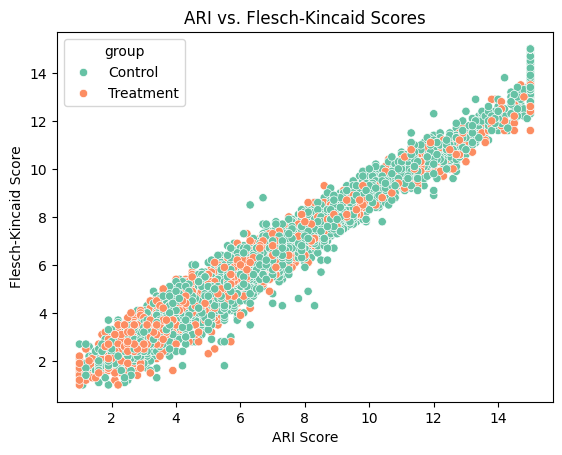

In [ ]:
# Plot scatter plot
sns.scatterplot(data=aggTweetsDf, x='ari_score', y='flesch_kincaid_grade', hue='group', palette="Set2")
#plt.scatter(aggTweetsDf["ari_score"], aggTweetsDf["flesch_kincaid_grade"])
plt.xlabel('ARI Score')
plt.ylabel('Flesch-Kincaid Score')
plt.title('ARI vs. Flesch-Kincaid Scores')
plt.show()

In [ ]:
# ANNOVA
from scipy.stats import f_oneway

# treatment vs. control
control = aggTweetsDf[(aggTweetsDf.group == 0) & (aggTweetsDf.ari_score < 15)]["ari_score"].values
treatment = aggTweetsDf[(aggTweetsDf.group == 1) & (aggTweetsDf.ari_score < 15)]["ari_score"].values

# Perform ANOVA
f_statistic, p_value = f_oneway(control, treatment)

# Print the results
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretation (assuming a significance level of 0.05)
if p_value < 0.05:
    print("There is a significant difference in ARI scores between control and treatment groups.")
else:
    print("There is no significant difference in ARI scores between control and treatment groups.")

F-statistic: nan
p-value: nan
There is no significant difference in ARI scores between control and treatment groups.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [ ]:
# Kruskal-Wallis
from scipy.stats import kruskal

# Perform the Kruskal-Wallis test
h_statistic, p_value = kruskal(control, treatment)

# Print the results
print(f"Kruskal-Wallis H-statistic: {h_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretation (assuming a significance level of 0.05)
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in ARI scores between the groups.")
else:
    print("There is no significant difference in ARI scores between the groups.")

Kruskal-Wallis H-statistic: nan
p-value: nan
There is no significant difference in ARI scores between the groups.


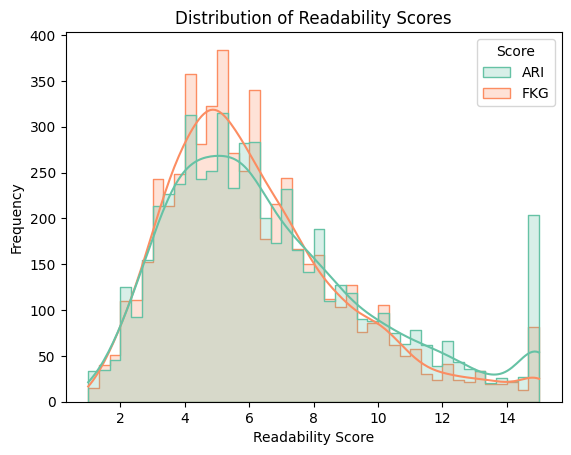

In [ ]:
# Plot a histogram for ari_score and flesch_kincaid_grade
ariDf = aggTweetsDf[["author_id", "ari_score"]].rename(columns = {"ari_score":"value"}).reset_index(drop = True)
fkDf = aggTweetsDf[["author_id", "flesch_kincaid_grade"]].rename(columns = {"flesch_kincaid_grade":"value"}).reset_index(drop = True)
ariDf["Score"] = "ARI"
fkDf["Score"] = "FKG"
plotingDf = pd.concat([ariDf, fkDf])

sns.histplot(data=plotingDf, x='value', hue='Score', element='step', palette="Set2", kde=True, legend=True)
plt.xlabel("Readability Score")
plt.ylabel("Frequency")
plt.title(f"Distribution of Readability Scores")
plt.show()

In [ ]:
aggTweetsDf.groupby("ari_grade")["author_id"].count().reset_index().rename({"author_id":"count"}, axis = 1)

,ari_grade,count
0,High School & College,1190
1,Middle/Elemntary School,4422


In [ ]:
aggTweetsDf.groupby("fk_grade")["author_id"].count().reset_index().rename({"author_id":"count"}, axis = 1)

,fk_grade,count
0,High School & College,891
1,Middle/Elemntary School,4721


### Save

In [ ]:
# Save the result to pickle
with open(os.path.join(demographicsDir, "authorEducationLevel.pickle"), "wb") as f:
    pickle.dump(aggTweetsDf, f)